In [ ]:
import os, sys, pickle, time
import pandas as pd
sys.path.append('./src/')
import oncofinder_v0 as ocf

import matplotlib.pyplot as plt
import numpy as np

import umap
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [2]:
import lightgbm
lightgbm.__version__

'3.1.1'

In [45]:
def getTopN(DF, N = 3):
    resDF = {}
    for ID in DF.index:
        resDF[ID] = DF.loc[ID,:].sort_values(ascending = False)[:N].index
    return pd.DataFrame(resDF).T

In [46]:
train_X = pd.read_csv('../../Modeling_240221/TRAIN_DATA/train_X_f8300.csv', index_col=0)
train_Y = pd.read_csv('../../Modeling_240221/TRAIN_DATA/train_Y_f8300.csv', index_col=0)
tX_1 = pd.read_csv('../../Modeling_240221/TRAIN_DATA/SMC_X_f8300.csv', index_col=0)
tY_1 = pd.read_csv('../../Modeling_240221/TRAIN_DATA/SMC_Y_f8300.csv', index_col=0)

In [48]:
TCs = ['AdrenalGland', 'BileDuct', 'Bladder', 'Brain', 'Breast', 
       'Colorectal', 'HeadAndNeck', 'Kidney', 'Liver', 
       'Lung', 'Ovary', 'Pancreas', 'Prostate', 
       'Skin', 'Stomach', 'Thyroid','Uterus']

In [49]:
len(TCs)
train_Y_f1 = train_Y[train_Y.OC_Tissue.isin(TCs)]
train_X_f1 = train_X.loc[train_Y_f1.index,:]

In [51]:
### OVR ###
def mkModel():
    clf2 = LogisticRegression(C = 10, penalty = 'l2', max_iter=100, random_state=3492, solver='liblinear', multi_class='ovr')
    clf3 = LGBMClassifier(learning_rate=0.01, n_estimators=2000, num_leaves=15, n_jobs=100, random_state=3492)
    clf3ovr = OneVsRestClassifier(clf3)
    clf7 = SVC(kernel='linear', C = 0.1, probability=True)
    clf7ovr = OneVsRestClassifier(clf7, n_jobs=20)

    clf_vot_ovr = VotingClassifier(estimators=[('logi', clf2), ('gbm', clf3ovr), ('svc', clf7ovr)], voting='soft')
    
    return clf_vot_ovr


In [107]:
### OVR ###
def mkModel2():
    clf2 = LogisticRegression(C = 10, penalty = 'l2', max_iter=100, random_state=3492, solver='liblinear', multi_class='ovr')
    clf3 = LGBMClassifier(learning_rate=0.01, n_estimators=2000, num_leaves=15, n_jobs=100, random_state=3492)
    clf7 = SVC(kernel='linear', C = 0.1, probability=True)

    clf_vot_ovr = VotingClassifier(estimators=[('logi', clf2), ('gbm', clf3), ('svc', clf7)], voting='soft')
    
    return clf_vot_ovr


### Validation OCP <-> TCGA

In [52]:
train_Y_f1_OCP = train_Y_f1[train_Y_f1.OC_Source == 'OCP']
train_Y_f1_TCGA = train_Y_f1[train_Y_f1.OC_Source == 'TCGA']
train_X_f1_OCP = train_X_f1.loc[train_Y_f1_OCP.index,:]
train_X_f1_TCGA = train_X_f1.loc[train_Y_f1_TCGA.index,:]

In [37]:
m_ocp = mkModel()
m_ocp.fit(train_X_f1_OCP, train_Y_f1_OCP.OC_Tissue)
pickle.dump(m_ocp, open('outputs/model_ocp.pkl', 'wb'))

m_tcga = mkModel()
m_tcga.fit(train_X_f1_TCGA, train_Y_f1_TCGA.OC_Tissue)
pickle.dump(m_tcga, open('outputs/model_tcga.pkl', 'wb'))

In [9]:
m_tcga = pickle.load(open('outputs/model_tcga.pkl', 'rb'))

In [ ]:
aucRes = {}
i = 0
for ix in train_X_f1.columns:
    if i % 100 == 0: print(i)
    i = i+1
    e_o = train_X_f1.loc[train_Y_f1[train_Y_f1.OC_Source == 'OCP'].index, ix]
    e_t = train_X_f1.loc[train_Y_f1[train_Y_f1.OC_Source == 'TCGA'].index, ix]

    a = [0]*len(e_o) + [1]*len(e_t); b = list(e_o) + list(e_t)
    metrics.roc_auc_score(a, b)

    aucRes[ix] = metrics.roc_auc_score(a, b)

plfauc = pd.DataFrame([aucRes], index=['AUC']).T

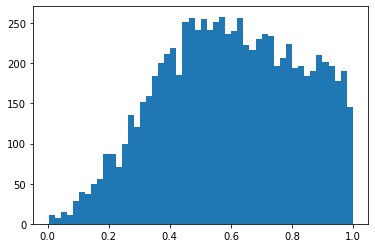

In [57]:
plt.hist(plfauc.AUC, bins=50)
plt.show()

In [59]:
pickle.dump(plfauc, open("mdls/_DATA_AUC.pkl", 'wb'))


In [86]:
## AUC cut modeling

for cut in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
    
    print(time.ctime())
    
    clf2 = mkModel()
    
    print(cut)
    plfauc_f1 = plfauc[(plfauc.AUC > 0.5-cut) & (plfauc.AUC < 0.5+cut)]
    FeaSelc = plfauc_f1.index
    
    cv_scores_rf = cross_val_score(clf2, train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue, cv=3)
    
    clf2.fit(train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue)
    
    Res = {'auc_cut':cut, 'model':clf2, 'feature':FeaSelc, 'cross_val_score':cv_scores_rf}
    
    pickle.dump(Res, open("mdls/AUC{}_f{}_v{}.pkl".format(cut, 
                                                          len(FeaSelc), 
                                                          round(cv_scores_rf.mean(), 3)), 'wb'))
    
    

Tue Mar 12 17:35:47 2024
0.05
Tue Mar 12 20:28:16 2024
0.15
Tue Mar 12 23:01:09 2024
0.2
Wed Mar 13 02:08:56 2024
0.25
Wed Mar 13 05:55:43 2024
0.3
Wed Mar 13 10:21:28 2024
0.35
Wed Mar 13 15:14:49 2024
0.4
Wed Mar 13 20:35:11 2024
0.45


In [110]:
## AUC cut modeling

for cut in [0.01, 0.02, 0.025, 0.03]:
    
    print(time.ctime())
    
    clf2 = mkModel2()
    
    print(cut)
    plfauc_f1 = plfauc[(plfauc.AUC > 0.5-cut) & (plfauc.AUC < 0.5+cut)]
    FeaSelc = plfauc_f1.index
    
    cv_scores_rf = cross_val_score(clf2, train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue, cv=3)
    
    clf2.fit(train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue)
    
    Res = {'auc_cut':cut, 'model':clf2, 'feature':FeaSelc, 'cross_val_score':cv_scores_rf}
    
    pickle.dump(Res, open("mdls_multi/AUC{}_f{}_v{}.pkl".format(cut, 
                                                                len(FeaSelc), 
                                                                round(cv_scores_rf.mean(), 3)), 'wb'))
    
    

Fri Mar 22 15:39:06 2024
0.01
Fri Mar 22 16:24:59 2024
0.02
Fri Mar 22 17:19:21 2024
0.025
Fri Mar 22 18:35:30 2024
0.03


In [ ]:
## AUC cut modeling

for cut in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    
    print(time.ctime())
    
    clf2 = mkModel2()
    
    print(cut)
    plfauc_f1 = plfauc[(plfauc.AUC > 0.5-cut) & (plfauc.AUC < 0.5+cut)]
    FeaSelc = plfauc_f1.index
    
    cv_scores_rf = cross_val_score(clf2, train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue, cv=3)
    
    clf2.fit(train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue)
    
    Res = {'auc_cut':cut, 'model':clf2, 'feature':FeaSelc, 'cross_val_score':cv_scores_rf}
    
    pickle.dump(Res, open("mdls_multi/AUC{}_f{}_v{}.pkl".format(cut, 
                                                                len(FeaSelc), 
                                                                round(cv_scores_rf.mean(), 3)), 'wb'))
    
    

Wed Mar 20 16:20:09 2024
0.05
Wed Mar 20 17:15:42 2024
0.1
Wed Mar 20 19:11:12 2024
0.15
Wed Mar 20 22:04:20 2024
0.2
Thu Mar 21 01:42:00 2024
0.25
Thu Mar 21 06:07:31 2024
0.3
Thu Mar 21 11:17:13 2024
0.35
Thu Mar 21 17:12:15 2024
0.4
Fri Mar 22 02:17:07 2024
0.45
Fri Mar 22 11:21:14 2024
0.5


In [106]:
## AUC cut modeling

for cut in [0.5]:
    
    print(time.ctime())
    
    clf2 = mkModel()
    
    print(cut)
    plfauc_f1 = plfauc[(plfauc.AUC > 0.5-cut) & (plfauc.AUC < 0.5+cut)]
    FeaSelc = plfauc_f1.index
    
    cv_scores_rf = cross_val_score(clf2, train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue, cv=3)
    
    clf2.fit(train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Tissue)
    
    Res = {'auc_cut':cut, 'model':clf2, 'feature':FeaSelc, 'cross_val_score':cv_scores_rf}
    
    pickle.dump(Res, open("mdls/AUC{}_f{}_v{}.pkl".format(cut, 
                                                          len(FeaSelc), 
                                                          round(cv_scores_rf.mean(), 3)), 'wb'))
    
    

Wed Mar 20 10:15:04 2024
0.5


In [105]:
## AUC cut modeling

for cut in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]:
    
    print(time.ctime())
    
    clf2 = mkModel()
    
    print(cut)
    plfauc_f1 = plfauc[(plfauc.AUC > 0.5-cut) & (plfauc.AUC < 0.5+cut)]
    FeaSelc = plfauc_f1.index
    
    cv_scores_rf = cross_val_score(clf2, train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Cancer, cv=3)
    
    clf2.fit(train_X_f1.loc[:,FeaSelc], train_Y_f1.OC_Cancer)
    
    Res = {'auc_cut':cut, 'model':clf2, 'feature':FeaSelc, 'cross_val_score':cv_scores_rf}
    
    pickle.dump(Res, open("mdls_OCcancer/AUC{}_f{}_v{}.pkl".format(cut, 
                                                                   len(FeaSelc), 
                                                                   round(cv_scores_rf.mean(), 3)), 'wb'))
    
    

Fri Mar 15 16:26:27 2024
0.05
Fri Mar 15 18:28:23 2024
0.1
Fri Mar 15 21:52:29 2024
0.15
Sat Mar 16 02:44:06 2024
0.2
Sat Mar 16 09:03:10 2024
0.25
Sat Mar 16 16:32:37 2024
0.3
Sun Mar 17 01:08:46 2024
0.35
Sun Mar 17 10:30:38 2024
0.4
Sun Mar 17 20:50:16 2024
0.45


### Cross validation Total

In [39]:
m_cv = mkModel()
cv_scores = cross_val_score(m_cv, 
                            train_X_f1, 
                            train_Y_f1.OC_Tissue, 
                            cv=5)
pickle.dump(cv_scores, open('outputs/cv_score.pkl', 'wb'))

## Final Model

In [38]:
m_fin = mkModel()
m_fin.fit(train_X_f1, train_Y_f1.OC_Tissue)
pickle.dump(m_fin, open('outputs/model_final.pkl', 'wb'))

### TCGA <- supportive OCP

In [ ]:
prd_t2o = m_tcga.predict(train_X_f1_OCP)

In [20]:
print(time.ctime())
prd_t2o = m_tcga.predict(train_X_f1_OCP)
print(time.ctime())

Tue Mar 12 11:28:51 2024
Tue Mar 12 11:47:35 2024


In [21]:
pickle.dump(prd_t2o, open('outputs/pred_t2o.pkl', 'wb'))

In [24]:
pd.DataFrame(classification_report(train_Y_f1_OCP.OC_Tissue, prd_t2o, output_dict=True)).T

,precision,recall,f1-score,support
AdrenalGland,0.803714,0.974277,0.880814,311.000000
Bladder,0.867347,0.822581,0.844371,310.000000
Brain,0.997585,0.946955,0.971611,3054.000000
Breast,0.964801,0.988995,0.976748,5543.000000
Colorectal,0.998428,0.620039,0.765001,3074.000000
HeadAndNeck,0.942761,0.450161,0.609358,622.000000
Kidney,0.772152,0.856742,0.812250,356.000000
Liver,0.948837,0.987893,0.967972,413.000000
Lung,0.836820,0.980829,0.903120,2243.000000
Ovary,0.978287,0.709536,0.822515,1143.000000


In [26]:
train_Y_f1_OCP_support = train_Y_f1_OCP[train_Y_f1_OCP.OC_Tissue == prd_t2o]

In [29]:
train_X_f1_OCP_support = train_X_f1_OCP.loc[train_Y_f1_OCP_support.index,:]

In [34]:
train_X_Sup = pd.concat([train_X_f1_TCGA,train_X_f1_OCP_support], axis = 0)
train_Y_Sup = pd.concat([train_Y_f1_TCGA,train_Y_f1_OCP_support], axis = 0)

In [38]:
pd.Series(train_Y_Sup.index == train_X_Sup.index).value_counts()

True    25169
dtype: int64

In [39]:
m_fin_sup = mkModel()
m_fin_sup.fit(train_X_Sup, train_Y_Sup.OC_Tissue)
pickle.dump(m_fin_sup, open('outputs/model_final_sup.pkl', 'wb'))

In [ ]:
m_fin_sup

In [41]:
ve_= getTopN(pd.DataFrame(m_fin_sup.predict_proba(tX_1.T), 
                          columns=m_fin_sup.classes_, 
                          index = tX_1.columns), N=4)

In [43]:
ve_.to_csv('outputs/mf_sup_pred_smc.csv')

## External validation

In [49]:
ve_= getTopN(pd.DataFrame(m_fin.predict_proba(tX_1.T), 
                          columns=m_fin.classes_, 
                          index = tX_1.columns), N=4)

In [51]:
ve_.to_csv('outputs/mf_pred_smc.csv')

In [3]:
pd.read_csv('outputs/mf_pred_smc.csv')

,Unnamed: 0,0,1,2,3
0,CUP76,Lung,Colorectal,Kidney,Prostate
1,CUP77,Colorectal,Stomach,Pancreas,Ovary
2,CUP78,Lung,Colorectal,Kidney,Pancreas
3,CUP79,Colorectal,Stomach,Pancreas,Brain
4,CUP81,Lung,Colorectal,Ovary,Kidney
...,...,...,...,...,...
81,Cup-71,Stomach,Pancreas,Bladder,Breast
82,Cup-72,Prostate,Bladder,Stomach,Pancreas
83,Cup-73,Liver,Stomach,Lung,Brain
84,Cup-74,Ovary,Stomach,Breast,Kidney
